In [1]:
# from collections import namedtuple
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, classification_report

In [2]:
np.random.seed(2021)

In [3]:
# Point = namedtuple('Point', ['x1','x2','y','color'])

@dataclass
class Point:
    x1: int
    x2: int
    y_true: int
    color: str

points = []
for i in range(200):
    x1 = 5 + 5 * np.random.randn()
    x2 = 5 + 5 * np.random.randn()
    points.append(Point(x1, x2, 1, 'blue'))
    
    x1 = -5 + 5 * np.random.randn()
    x2 = -5 + 5 * np.random.randn()
    points.append(Point(x1, x2, 0, 'red'))

points[0]

Point(x1=12.443045263347564, x2=8.38005435701196, y_true=1, color='blue')

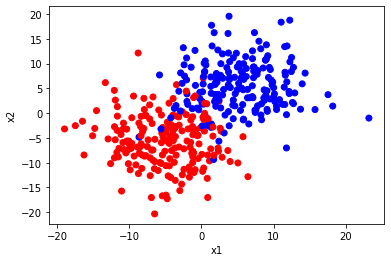

In [4]:
plt.scatter(
    x = [p.x1 for p in points],
    y = [p.x2 for p in points],
    c = [p.color for p in points]
)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [5]:
class PointsDataset(Dataset):
    def __init__(self, points):
        self.coordinates = [[p.x1, p.x2] for p in points]
        self.labels = [p.y_true for p in points]
        
    def class_count(self):
        return {
            '0': sum([1 for l in self.labels if l == 0]),
            '1': sum([1 for l in self.labels if l == 1])
        }
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return torch.tensor(self.coordinates[idx]), torch.tensor([self.labels[idx]], dtype = torch.float32)

In [6]:
np.random.shuffle(points)
n_train = int(0.8 * len(points))
points_train = points[:n_train]
points_test = points[n_train:]

dataset_train = PointsDataset(points_train)
dataset_test = PointsDataset(points_test)

print(f'Train: {len(dataset_train), dataset_train.class_count()}')
print(f'Test: {len(dataset_test), dataset_test.class_count()}')

Train: (320, {'0': 161, '1': 159})
Test: (80, {'0': 39, '1': 41})


In [7]:
input_dim = 2
output_dim = 1
batch_size = 8
epochs = 5
learning_rate = 0.01

In [8]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, X):
        outputs = self.linear(X)
        return outputs
    
model = LogisticRegression(input_dim, output_dim)
model

LogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

In [9]:
model.train()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = learning_rate)

dataloader_train = DataLoader(dataset_train, batch_size = batch_size)
dataloader_test = DataLoader(dataset_test, batch_size = batch_size)

train_losses = []
for epoch in range(epochs):
    batch_losses = []
    for features, targets in dataloader_train:
        # Get model outputs and compute loss
        outputs = model(features)
        loss = criterion(outputs, targets)
        batch_losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = np.average(batch_losses)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch + 1} loss: {epoch_loss}")

Epoch 1 loss: 0.23732968356925993
Epoch 2 loss: 0.19799013413721694
Epoch 3 loss: 0.19088486762484536
Epoch 4 loss: 0.18874448761343957
Epoch 5 loss: 0.18785318663576617


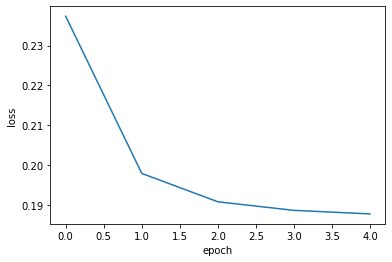

In [10]:
plt.plot(train_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [11]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[0.4033, 0.3615]], requires_grad=True)
Parameter containing:
tensor([-0.2640], requires_grad=True)


In [12]:
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for features, targets in dataloader_test:
        outputs = model(features)
        y_true.extend(targets.to(dtype = torch.long).squeeze().detach().tolist())
        probabilities = torch.sigmoid(outputs).squeeze().detach().tolist()
        y_pred.extend([1 if p >= 0.5 else 0 for p in probabilities])

In [13]:
for metric in [accuracy_score, f1_score, roc_auc_score]:
    print(f'{metric.__name__}: {round(metric(y_true, y_pred), 4)}')

accuracy_score: 0.95
f1_score: 0.9524
roc_auc_score: 0.9493


In [14]:
confusion_matrix(y_true, y_pred)

array([[36,  3],
       [ 1, 40]])

In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95        39
           1       0.93      0.98      0.95        41

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80

